In [2]:
import os
import pandas as pd
import numpy as np
import keras
from keras import layers
import tensorflow as tf
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [7]:
os.getcwd()

'/home/kevin/traffic_signs/roadtrafficsigns'

In [8]:
os.chdir('/home/kevin')

In [9]:
dataset_directory = "trafficsigns_dataset"

#Gets class names by listing directories
class_names = sorted(os.listdir(dataset_directory))  # Ensure it's sorted to match the order used by TensorFlow
print("Class names:", class_names)

#prints class name and corresponding index
print("Class names and their corresponding indices:")
for index, name in enumerate(class_names):
    print(f"Class {index}: {name}")

Class names: ['diamond', 'hex', 'round', 'square', 'triangle']
Class names and their corresponding indices:
Class 0: diamond
Class 1: hex
Class 2: round
Class 3: square
Class 4: triangle


In [10]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Setting 20% of the data for validation
)


In [11]:
# Directory where your images are stored
directory = 'trafficsigns_dataset/'

# Training generator
train_generator = datagen.flow_from_directory(
    directory,
    target_size=(28, 28),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training'
)

# Validation generator
validation_generator = datagen.flow_from_directory(
    directory,
    target_size=(28, 28),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation'
)

Found 2946 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


In [12]:
import scipy
from scipy.ndimage import gaussian_filter, binary_dilation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [13]:
#confirming shape of images
batch_size = 32
train_dataset = train_generator[0]

# Print the shapes of the images and labels
print("Images shape:", train_dataset[0].shape)
print("Labels shape:", train_dataset[1].shape)

Images shape: (32, 28, 28, 1)
Labels shape: (32, 5)


In [14]:
num_classes = 5

model = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (5, 5), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')  # Use 'softmax' for multi-class classification
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

/home/kevin/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15


/home/kevin/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 0.4660 - loss: 1.2925 - val_accuracy: 0.4886 - val_loss: 1.2405
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5938 - loss: 1.0514 - val_accuracy: 0.6774 - val_loss: 0.9063
Epoch 3/15


2024-05-09 13:05:31.004804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-05-09 13:05:31.049114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.5865 - loss: 1.0425 - val_accuracy: 0.5710 - val_loss: 1.1591
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.5625 - loss: 1.0307 - val_accuracy: 0.5161 - val_loss: 1.2319
Epoch 5/15


2024-05-09 13:05:41.257398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-09 13:05:41.299693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.6449 - loss: 0.9178 - val_accuracy: 0.6577 - val_loss: 1.0624
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.8106 - val_accuracy: 0.6129 - val_loss: 0.9497
Epoch 7/15


2024-05-09 13:05:50.530633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-09 13:05:50.575303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.7127 - loss: 0.7823 - val_accuracy: 0.6932 - val_loss: 0.8955
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - accuracy: 0.6250 - loss: 0.8548 - val_accuracy: 0.6129 - val_loss: 1.0314
Epoch 9/15


2024-05-09 13:06:00.319079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-09 13:06:00.364198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.7283 - loss: 0.7217 - val_accuracy: 0.7173 - val_loss: 0.7809
Epoch 10/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.8750 - loss: 0.4006 - val_accuracy: 0.5161 - val_loss: 1.2629
Epoch 11/15


2024-05-09 13:06:09.851562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-09 13:06:09.890156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.7834 - loss: 0.5787 - val_accuracy: 0.7173 - val_loss: 0.8006
Epoch 12/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5000 - loss: 1.2997 - val_accuracy: 0.6452 - val_loss: 0.9755
Epoch 13/15


2024-05-09 13:06:19.119154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-09 13:06:19.175586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.7827 - loss: 0.5718 - val_accuracy: 0.7642 - val_loss: 0.7120
Epoch 14/15
 1/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.7812 - loss: 0.4969

2024-05-09 13:06:28.625026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-09 13:06:28.654806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7812 - loss: 0.4969 - val_accuracy: 0.7742 - val_loss: 0.7283
Epoch 15/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.8140 - loss: 0.4934 - val_accuracy: 0.8139 - val_loss: 0.5885


In [ ]:
# epochs = 15
# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
# ]
# history = model.fit(
#     train_generator,
#     epochs=epochs,
#     callbacks=callbacks,
#     validation_data=validation_generator,
# )

### plot Validation Loss and Training Loss

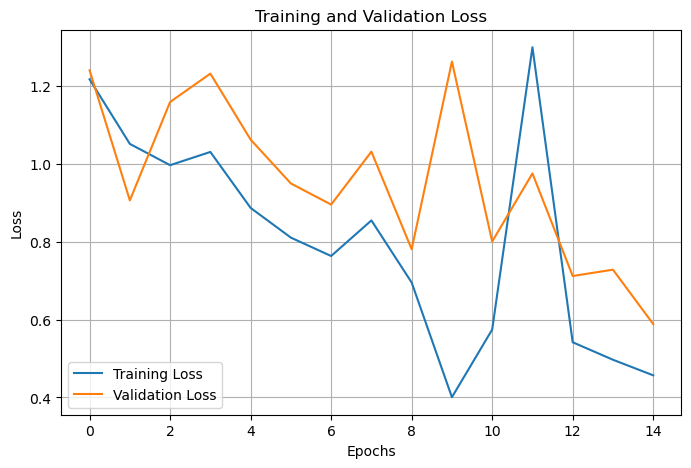

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Plot Validation Accuracy and Training Accuracy

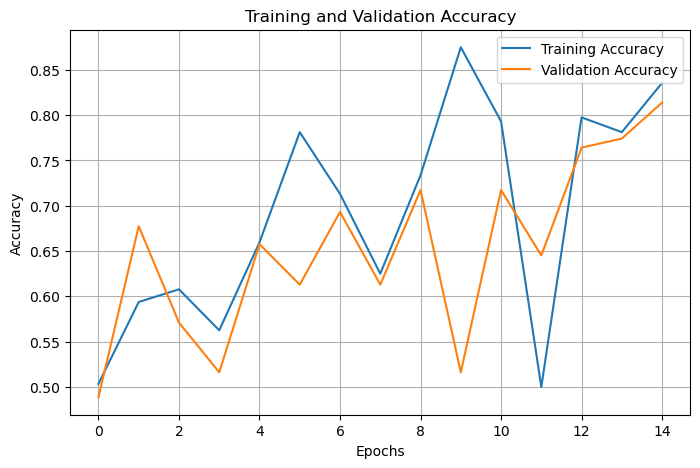

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Change 'loss' to 'accuracy'
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Change 'val_loss' to 'val_accuracy'
plt.title('Training and Validation Accuracy')  # Change title to Accuracy
plt.xlabel('Epochs')
plt.ylabel('Accuracy')  # Change Y-axis label to Accuracy
plt.legend()
plt.grid(True)
plt.show()

### Detecting Sign Type

In [17]:
# Get image names from sign-type directories
rw = sorted(os.listdir("trafficsigns_dataset/diamond/rightofway"))
st = sorted(os.listdir("trafficsigns_dataset/hex/stop"))
bc = sorted(os.listdir("trafficsigns_dataset/round/bicycle"))
lt = sorted(os.listdir("trafficsigns_dataset/round/limitedtraffic"))
ne = sorted(os.listdir("trafficsigns_dataset/round/noentry"))
np = sorted(os.listdir("trafficsigns_dataset/round/noparking"))
ra = sorted(os.listdir("trafficsigns_dataset/round/roundabout"))
sp = sorted(os.listdir("trafficsigns_dataset/round/speed"))
td = sorted(os.listdir("trafficsigns_dataset/round/trafficdirective"))
trvd = sorted(os.listdir("trafficsigns_dataset/round/traveldirection"))
ct = sorted(os.listdir("trafficsigns_dataset/square/continue"))
cr = sorted(os.listdir("trafficsigns_dataset/square/crossing"))
le = sorted(os.listdir("trafficsigns_dataset/square/laneend"))
pk = sorted(os.listdir("trafficsigns_dataset/square/parking"))
gw = sorted(os.listdir("trafficsigns_dataset/triangle/giveway"))
wn = sorted(os.listdir("trafficsigns_dataset/triangle/warning"))

In [18]:
sign_type_dict = []

for i in rw:
  sign_type_dict.append(["trafficsigns_dataset/diamond/rightofway/" + i,"rightofway"])

for i in st:
  sign_type_dict.append(["trafficsigns_dataset/hex/stop/" + i,"stop"])

for i in bc:
  sign_type_dict.append(["trafficsigns_dataset/round/bicycle/" + i,"bicycle"])

for i in lt:
  sign_type_dict.append(["trafficsigns_dataset/round/limitedtraffic/" + i,"limitedtraffic"])

for i in ne:
  sign_type_dict.append(["trafficsigns_dataset/round/noentry/" + i,"noentry"])

for i in np:
  sign_type_dict.append(["trafficsigns_dataset/round/noparking/" + i,"noparking"])

for i in ra:
  sign_type_dict.append(["trafficsigns_dataset/round/roundabout/" + i,"roundabout"])

for i in sp:
  sign_type_dict.append(["trafficsigns_dataset/round/speed/" + i,"speed"])

for i in td:
  sign_type_dict.append(["trafficsigns_dataset/round/trafficdirective/" + i,"trafficdirective"])

for i in trvd:
  sign_type_dict.append(["trafficsigns_dataset/round/traveldirection/" + i,"traveldirection"])

for i in ct:
  sign_type_dict.append(["trafficsigns_dataset/square/continue/" + i,"continue"])

for i in cr:
  sign_type_dict.append(["trafficsigns_dataset/square/crossing/" + i,"crossing"])

for i in le:
  sign_type_dict.append(["trafficsigns_dataset/square/laneend/" + i,"laneend"])

for i in pk:
  sign_type_dict.append(["trafficsigns_dataset/square/parking/" + i,"parking"])

for i in gw:
  sign_type_dict.append(["trafficsigns_dataset/triangle/giveway/" + i,"giveway"])

for i in wn:
  sign_type_dict.append(["trafficsigns_dataset/triangle/warning/" + i,"warning"])

In [19]:
stdf = pd.DataFrame(data=sign_type_dict, columns=['imgPath', 'class'])

stdf.head()

,imgPath,class
0,trafficsigns_dataset/diamond/rightofway/00032_...,rightofway
1,trafficsigns_dataset/diamond/rightofway/00032_...,rightofway
2,trafficsigns_dataset/diamond/rightofway/00032_...,rightofway
3,trafficsigns_dataset/diamond/rightofway/00037_...,rightofway
4,trafficsigns_dataset/diamond/rightofway/00037_...,rightofway


In [20]:
train_data, test_data = train_test_split(stdf, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

In [21]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [22]:
INPUT_DIM = (28,28,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 16

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

/home/kevin/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       602,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         4,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 606,480 (2.31 MB)

 Trainable params: 606,480 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [27]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [28]:
train_data['class'] = train_data['class'].astype('str')
val_data['class'] = val_data['class'].astype('str')

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 28

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="imgPath",
        y_col="class",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="imgPath",
        y_col="class",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2208 validated image filenames belonging to 16 classes.
Found 736 validated image filenames belonging to 16 classes.


/home/kevin/.local/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="imgPath". These filename(s) will be ignored.
  warnings.warn(


In [30]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=15, verbose=0)

/home/kevin/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


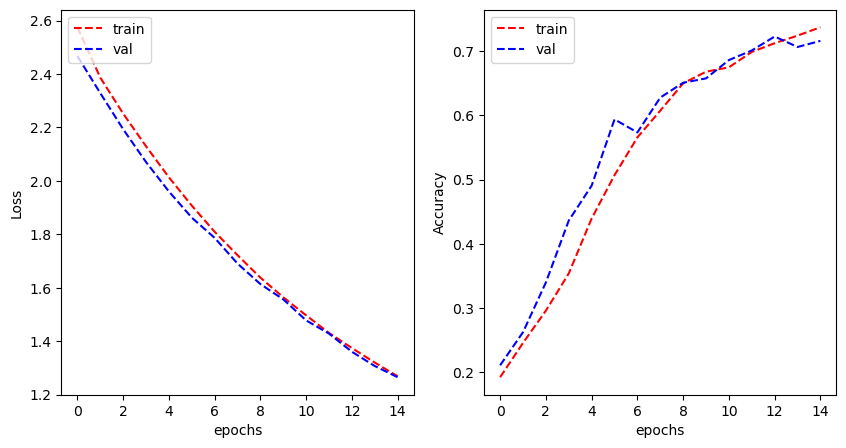

In [31]:
plot_learning_curve(history.history['loss'], history.history['val_loss'],
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [32]:
test_data['class'] = test_data['class'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="imgPath",
        y_col="class",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 736 validated image filenames belonging to 16 classes.


/home/kevin/.local/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="imgPath". These filename(s) will be ignored.
  warnings.warn(


In [33]:
model.evaluate(test_generator)

 36/736 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - categorical_accuracy: 0.5245 - loss: 1.7958  

/home/kevin/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


736/736 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - categorical_accuracy: 0.6991 - loss: 1.3092


[1.265293002128601, 0.7160326242446899]

In [34]:
label_names = {'rightofway' : 0, 'stop' : 1, 'bicycle' : 2, 'limitedtraffic' : 3, 'noentry' : 4, 'noparking' : 5, 'roundabout' : 6, 'speed' : 7, 'trafficdirective' : 8, 'traveldirection' : 9,
               'continue' : 10, 'crossing' : 11, 'laneend' : 12, 'parking' : 13, 'giveway' : 14, 'warning' : 15}

In [36]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))

        else:
            break

        plt.axis('off')

AttributeError: 'list' object has no attribute 'squeeze'

<Figure size 1600x400 with 0 Axes>